# Linear Regression

- Morning
  - How do I find the line that minimizes squared error?
  - What distributional assumptions does Linear Regression make?
  - What statistical claims (hypotheses) do I get to make about regression coefficients & predictions?
  - How can I check the validity of LR's assumptions?
  - **Always Plot The Residuals**
    - Are they homoscedastic?
    - Are they normal?
  - What is multicollinearity and how do I deal with it?
  
- Afternoon
  - What are some more evaluation metrics?
  - How do I interpret coefficients for categorical features?
  - How can I transform my data so that it is more linear & homoscedastic?

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

font = {'size'   : 14}

matplotlib.rc('font', **font)


Let's look at the `cars` data set

In [2]:
cars = pd.read_csv('data/cars_multivariate.csv')
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [4]:
cars.describe()

,mpg,cylinders,displacement,weight,acceleration,model,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [5]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


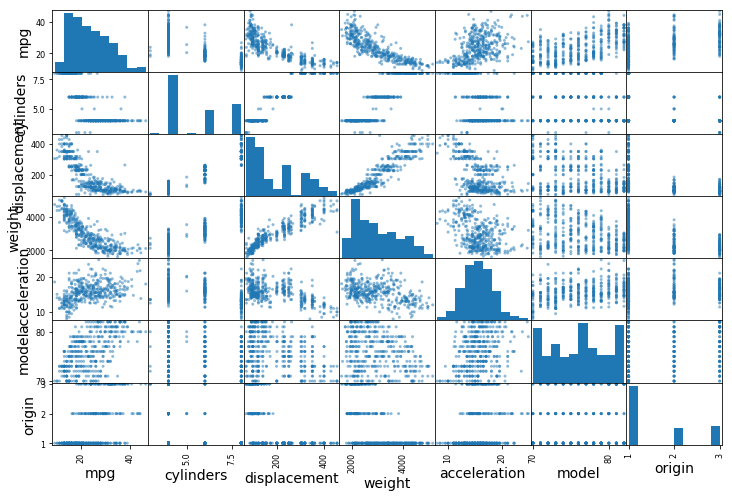

In [6]:
pd.plotting.scatter_matrix(cars, figsize=(12,8));

## Linear Regression

What is it? We are hypothesizing a **linear relationship** between a *target* (or 'endogenous' variable) and some *features* (predictors, or 'exogenous' variables).

In the case of a **single** feature, we are looking to quantify the relationship of the form
$$ y = mx + b $$

Let's select `mpg` as our target and `weight` as our predictor.

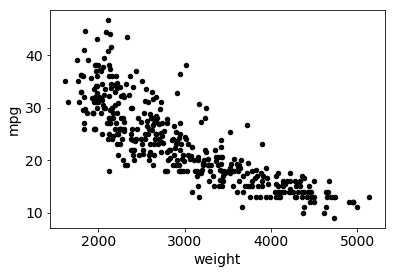

In [7]:
y = cars['mpg']
X = cars['weight']

plt.scatter(X,y, color='k', s=20)
plt.xlabel('weight')
plt.ylabel('mpg')
plt.show()

There are lots of lines we could draw... how do we pick a "best" line?

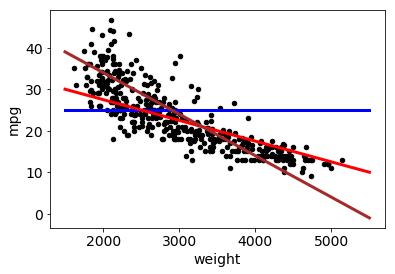

In [8]:
xx = np.linspace(1500,5500)
line0 = 0*xx + 25
line1 = (-1/200)*(xx - 1500) + 30
line2 = (-1/100)*(xx - 1500) + 39

plt.scatter(X,y, color='k', s=20)
plt.xlabel('weight')
plt.ylabel('mpg')
plt.plot(xx, line0, color='b', lw=3)
plt.plot(xx, line1, color='r', lw=3)
plt.plot(xx, line2, color='brown', lw=3);

Let's call our line $\hat{y}$. For any point $x_i$, we have our observed value $y_i$ and our value predicted from our line $$\hat{y}_i = \beta_0 + \beta_1 x_i$$

The *residual* is the distance between our predicted value and the actual value
$$r_i = y_i - \hat{y}_i$$

Let's find the line that minimizes the total **sum of squared residuals** (SSR)
$$ SSR = \sum_{i=1}^N (y_i - \hat{y}_i)^2 $$

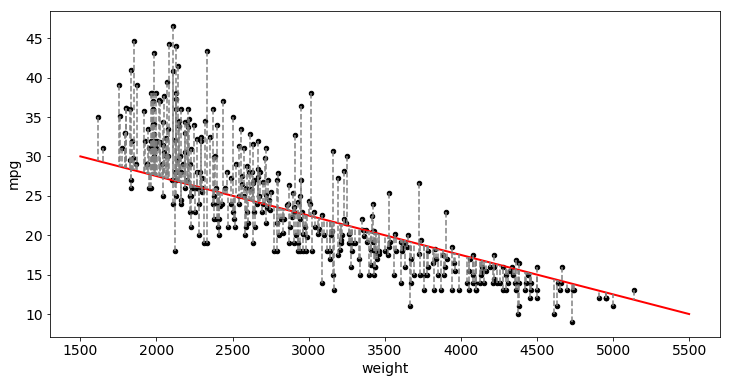

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(X,y, color='k', s=20)
plt.xlabel('weight')
plt.ylabel('mpg')

b0 = (1500/200) + 30
b1 = (-1/200)

line1 = b0 + b1*xx
plt.plot(xx, line1, color='r', lw=2)

for x_i, y_i in zip(X,y):
    plt.plot([x_i, x_i], [y_i, b1*x_i+b0], color='gray', linestyle='dashed')

#### Fun exercise: show that the line that minimizes the SSR in the single feature case is

$$ \hat{\beta}_1 = \frac{\sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^N (x_i - \bar{x})^2} = \frac{Cov(x,y)}{Var(x)}$$

$$\beta_0 = \bar{y} - \hat{\beta}_1\bar{x}$$

## Using statsmodels

In [10]:
y = cars['mpg']
X = sm.add_constant(cars['weight'])

In [11]:
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

In [12]:
X.head()

,const,weight
0,1.0,3504.0
1,1.0,3693.0
2,1.0,3436.0
3,1.0,3433.0
4,1.0,3449.0


In [13]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [14]:
simple_model = sm.OLS(y, X)
simple_results = simple_model.fit()
simple_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     888.9
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          2.97e-103
Time:                        16:40:17   Log-Likelihood:                -1148.4
No. Observations:                 398   AIC:                             2301.
Df Residuals:                     396   BIC:                             2309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.3174      0.795     58.243      0.000      44.754      47.881
weight        -0.0077      0.000    -29.814      0.000      -0.008      -0.007
==============================================================================
Omnibus:                       40.423   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.695
Skew:                           0.713   Prob(JB):                     4.89e-13
Kurtosis:                       4.176   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
simple_results.params

const     46.317364
weight    -0.007677
dtype: float64

In [16]:
X.head()

,const,weight
0,1.0,3504.0
1,1.0,3693.0
2,1.0,3436.0
3,1.0,3433.0
4,1.0,3449.0


In [17]:
simple_results.predict([1, 3400])

array([ 20.2168902])

In [18]:
simple_results.predict(sm.add_constant(cars['weight'])).head()

0    19.418523
1    17.967643
2    19.940532
3    19.963562
4    19.840736
dtype: float64

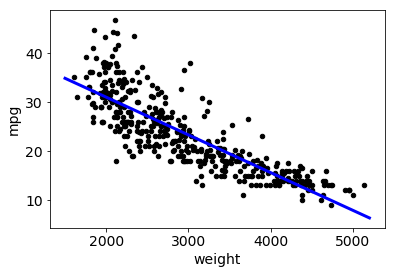

In [19]:
xx = np.linspace(1500,5200)
best_line = simple_results.params['const'] + simple_results.params['weight']*xx

plt.scatter(X['weight'],y, color='k', s=20)
plt.xlabel('weight')
plt.ylabel('mpg')
plt.plot(xx, best_line, color='b', lw=3);

In [20]:
simple_results.predict([1,-20000])

array([ 199.8495657])

## What about multiple features?

Assume we have $p$ features.

Then the linear relationship we are assuming has the form
$$ y = \beta_0*1 + \beta_1* X_1 + \beta_2*X_2 + ... + \beta_p *X_p $$

which we can write as the matrix product
$$Y = X\beta$$
where $Y$ is an $n \times 1$ column vector, $X$ is an $n \times (p+1)$ feature matrix (we've added a column of ones to encode the intercept term), and $\beta$ is a $(p+1) \times 1$ column vector

#### Even more fun exercise
Show that the vector of parameter values $\hat{\beta}$ that minimizes the SSR in the general case is the solution to the matrix equation

 $$ X^T X \hat{\beta} = X^T y $$
 
 Which can also be written as $\hat{\beta} = (X^TX)^{-1}X^Ty$
 
 



## What is regression in more than one dimension?

Let's plot `mpg` against `weight` and `acceleration`

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

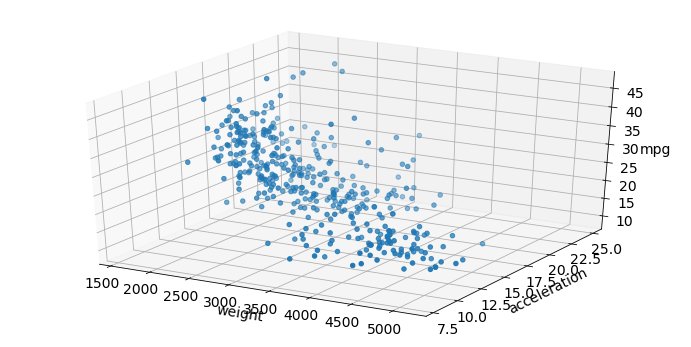

In [22]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cars['weight'], cars['acceleration'], cars['mpg'])
ax.set_zlabel('mpg')
ax.set_xlabel('weight')
ax.set_ylabel('acceleration');

Linear regression then finds the **plane** that minimizes SSR.

In [23]:
y = cars['mpg']
X = sm.add_constant(cars[['weight','acceleration']])
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          1.69e-103
Time:                        16:40:18   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.3998      1.865     22.201      0.000      37.734      45.066
weight          -0.0073      0.000    -26.131      0.000      -0.008      -0.007
acceleration     0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
results.params

const           41.399828
weight          -0.007336
acceleration     0.250816
dtype: float64

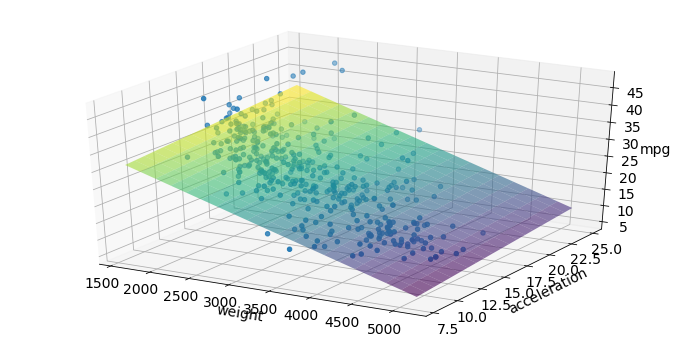

In [25]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cars['weight'], cars['acceleration'], cars['mpg']);
ax.set_zlabel('mpg')
ax.set_xlabel('weight')
ax.set_ylabel('acceleration');

xx1 = np.linspace(cars['weight'].min(), cars['weight'].max(), 20)
xx2 = np.linspace(cars['acceleration'].min(), cars['acceleration'].max(), 20)
xx1, xx2 = np.meshgrid(xx1, xx2)
best_plane = (results.params['const'] +
              results.params['weight']*xx1 +
              results.params['acceleration']*xx2)

# Plot the surface.
surf = ax.plot_surface(xx1, xx2, best_plane, color='k', alpha=.6, cmap='viridis')


## What was all that other stuff in the summary?

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          1.69e-103
Time:                        16:40:19   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.3998      1.865     22.201      0.000      37.734      45.066
weight          -0.0073      0.000    -26.131      0.000      -0.008      -0.007
acceleration     0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## $R^2$ : The "proportion of variance explained"

Let's for a moment refer to the variance of $y$ as "the total sum of squares"
$$ SST = \sum_i^N (y_i - \bar{y})^2 $$

Then we define $R^2$ as the percentage of that variance that has been "captured" by the regression line
$$
\begin{align}
    R^2 &:= 1 - \frac{SSR}{SST} \\
    &= 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
\end{align}    
$$

## p-values? Confidence intervals? WHAT'S GOING ON

It turns out we don't just want to solve an optimization problem.

We want to make **statistical claims** about this linear relationship. In order to do that, we need to assume a distribution, so here we go.

$$ y = \beta X + \epsilon $$
where
$$ \epsilon \sim Normal(0, \sigma^2) $$

Equivalently, we can write
$$ y \sim Normal(\beta X, \sigma^2) $$

With some work, you can show the following:
 - Given a set of $N$ observations $\{(x_i, y_i)\}$, where $x_i$ is a $p$-dimensional vector, the maximum likelihood estimate for $\beta$ is the same as the least-squares estimate: $$\hat{\beta} = (X^TX)^{-1}X^Ty$$
 so our model is $\hat{y} = \hat{\beta}X$
 - The sampling distribution of $\beta$ is: $$ \hat{\beta} \sim Normal(\beta, (X^T X)^{-1}\sigma^2)$$
 - The unbiased estimate of $\sigma^2$ is $$\hat{\sigma}^2 = \frac{SSR}{N-p} = \frac{\sum_i^N(y_i - \hat{y}_i)^2}{N-p}$$
   - using this estimate, we can construct confidence bounds on our parameters using the student's t distribution: $$ \hat{\beta}_j \, \pm t_{N-p} \sqrt{(X^T X)^{-1}_{jj}\frac{SSR}{N-p}}$$

Now all our null hypotheses have the form "Does $\beta_i = 0$ ?"

### What assumptions must hold in order to make these statistical statements?
Test your assumptions by **plotting your residuals**

#### Linearity: violated when you see nonlinear trends in your residuals

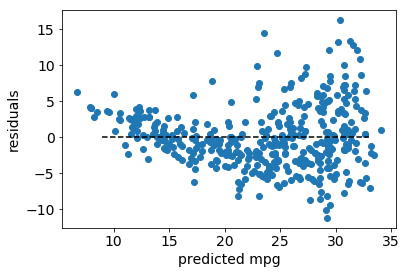

In [27]:
plt.scatter(results.fittedvalues, results.resid)
plt.hlines(0,9, 33, 'k', linestyle='dashed')
plt.xlabel('predicted mpg')
plt.ylabel('residuals');

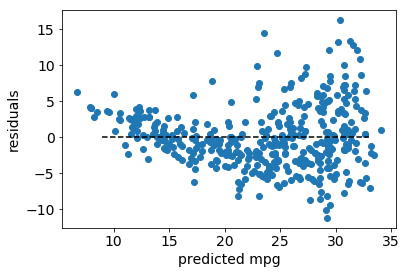

In [28]:
plt.scatter(results.fittedvalues, results.resid)
plt.hlines(0,9, 33, 'k', linestyle='dashed')
plt.xlabel('predicted mpg')
plt.ylabel('residuals');

Most of the time we want to work with the studentized residuals:

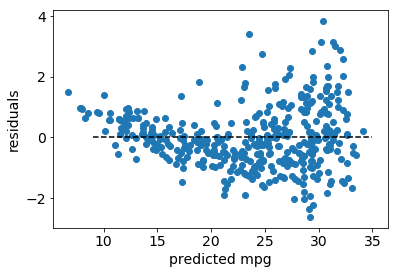

In [29]:
stud_resids = results.outlier_test()['student_resid']

plt.scatter(results.fittedvalues, stud_resids)
plt.hlines(0,9, 35, 'k', linestyle='dashed')
plt.xlabel('predicted mpg')
plt.ylabel('residuals');

#### Homoscedasticity: violated when the variance of your residuals isn't constant

There's a hypothesis test for this, the Goldfeld-Quandt test. It returns the p-value under the null hypothesis of homoscedasticity.

In [30]:
sm.stats.diagnostic.het_goldfeldquandt(y, X)

(2.4531975505435519, 3.3475952333844793e-10, 'increasing')

Pretty small p-val. Reject the null. Houston, we have heteroscedasticity.

#### Normality: violated when the residuals are not normally distributed

The tools for this are the Q-Q plot and the Jarque-Bera test.

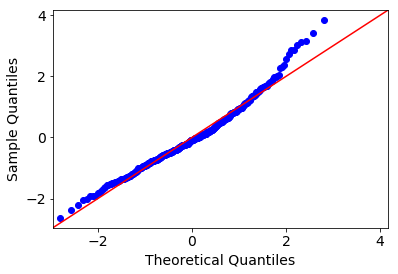

In [31]:
ax = sm.graphics.qqplot(stud_resids, line='45')

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          1.69e-103
Time:                        16:40:20   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.3998      1.865     22.201      0.000      37.734      45.066
weight          -0.0073      0.000    -26.131      0.000      -0.008      -0.007
acceleration     0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Multicollinearity: strictly violated when one feature is a linear combination of others, loosely violated when one feature is highly correlated with others

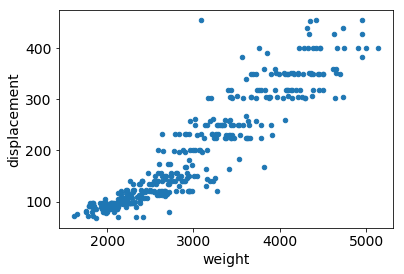

In [33]:
cars.plot.scatter('weight','displacement');

In [34]:
y = cars['mpg']
X = sm.add_constant(cars[['weight','acceleration']])
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          1.69e-103
Time:                        16:40:20   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.3998      1.865     22.201      0.000      37.734      45.066
weight          -0.0073      0.000    -26.131      0.000      -0.008      -0.007
acceleration     0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
y = cars['mpg']
X = sm.add_constant(cars[['weight','acceleration', 'displacement']])
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     307.0
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          1.01e-102
Time:                        16:40:20   Log-Likelihood:                -1142.7
No. Observations:                 398   AIC:                             2293.
Df Residuals:                     394   BIC:                             2309.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.2991      1.861     22.186      0.000      37.639      44.959
weight          -0.0062      0.001     -8.368      0.000      -0.008      -0.005
acceleration     0.1739      0.098      1.783      0.075      -0.018       0.366
displacement    -0.0109      0.007     -1.675      0.095      -0.024       0.002
==============================================================================
Omnibus:                       36.015   Durbin-Watson:                   0.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.328
Skew:                           0.681   Prob(JB):                     5.28e-11
Kurtosis:                       4.000   Cond. No.                     2.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

One measure of multicollinearity: the Variance Inflation Factor. Regress feature $X_k$ on all the rest of the features and get the $R^2$ value for that fit.

$$VIF_k = \frac{1}{1 - R_k^2}$$

Rule of thumb: collinearity is high if VIF > 10

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [37]:
variance_inflation_factor(X.values, 1)

8.4448390593787348

close call

# Afternoon: transformations & categorical variables

Let's go back to the `cars` data for a bit. Remember how it wasn't really very linear?

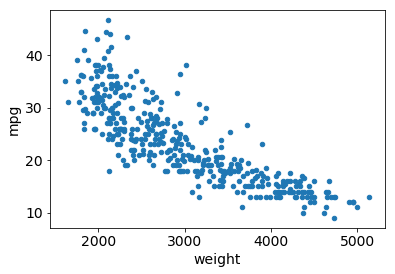

In [38]:
cars.plot.scatter('weight','mpg');

In [39]:
y = cars['mpg']
X2 = sm.add_constant(cars['weight'])

In [40]:
model = sm.OLS(y, X2)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     888.9
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          2.97e-103
Time:                        16:40:20   Log-Likelihood:                -1148.4
No. Observations:                 398   AIC:                             2301.
Df Residuals:                     396   BIC:                             2309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.3174      0.795     58.243      0.000      44.754      47.881
weight        -0.0077      0.000    -29.814      0.000      -0.008      -0.007
==============================================================================
Omnibus:                       40.423   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.695
Skew:                           0.713   Prob(JB):                     4.89e-13
Kurtosis:                       4.176   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

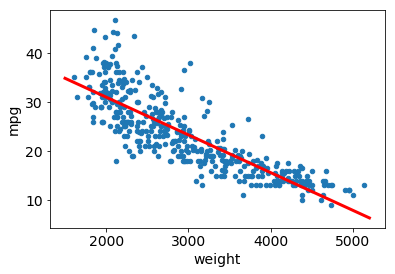

In [41]:
xx = np.linspace(1500, 5200)
ax = cars.plot.scatter('weight','mpg')
ax.plot(xx, results.predict(sm.add_constant(xx)), color='r', lw=3);

What if I think the `mpg` has a nonlinear relationship with `weight`? Something like
$$ y = ax + bx^2 + d e^{0.001x} $$

Well, I can just create new features that are transformations of $x$, then perform linear regression on those features.

In [42]:
X2['weight2'] = X2['weight']**2
X2['eweight'] = np.exp(X2['weight']/1000)

In [43]:
X2.head()

,const,weight,weight2,eweight
0,1.0,3504.0,12278016.0,33.248179
1,1.0,3693.0,13638249.0,40.165162
2,1.0,3436.0,11806096.0,31.062459
3,1.0,3433.0,11785489.0,30.969412
4,1.0,3449.0,11895601.0,31.468908


In [44]:
model2 = sm.OLS(y, X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     329.2
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          6.21e-107
Time:                        16:40:21   Log-Likelihood:                -1132.9
No. Observations:                 398   AIC:                             2274.
Df Residuals:                     394   BIC:                             2290.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.1393      6.180     10.217      0.000      50.990      75.289
weight        -0.0192      0.005     -3.955      0.000      -0.029      -0.010
weight2     1.832e-06   1.05e-06      1.750      0.081   -2.26e-07    3.89e-06
eweight       -0.0073      0.063     -0.115      0.909      -0.132       0.117
==============================================================================
Omnibus:                       51.914   Durbin-Watson:                   0.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.374
Skew:                           0.786   Prob(JB):                     6.45e-20
Kurtosis:                       4.691   Cond. No.                     3.23e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
p = results2.params
p

const      63.139285
weight     -0.019151
weight2     0.000002
eweight    -0.007280
dtype: float64

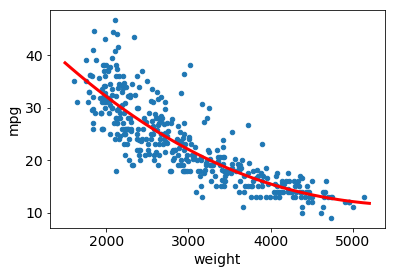

In [46]:
xx = np.linspace(1500, 5200)
curve = p['const'] + p['weight']*xx + p['weight2']*(xx**2) + p['eweight']*(np.exp(xx/1000))
ax = cars.plot.scatter('weight','mpg')
ax.plot(xx, curve, color='r', lw=3);

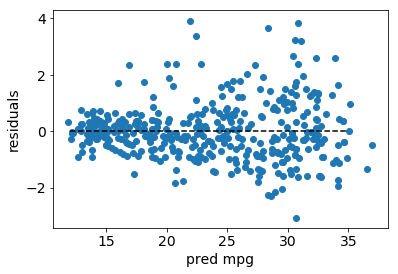

In [47]:
stud_resids2 = results2.outlier_test()['student_resid']

plt.scatter(results2.fittedvalues, stud_resids2)
plt.hlines(0,12, 35, 'k', linestyle='dashed')
plt.xlabel('pred mpg')
plt.ylabel('residuals');

You can transform $y$ also

In [48]:
y_logged = np.log(cars['mpg'])

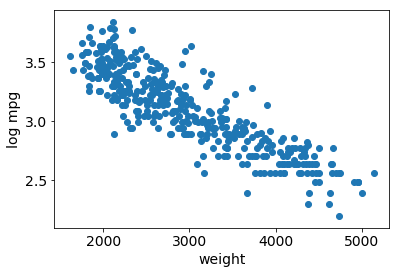

In [49]:
plt.scatter(cars['weight'], y_logged)
plt.xlabel('weight')
plt.ylabel('log mpg');

In [50]:
model3 = sm.OLS(y_logged, sm.add_constant(cars['weight']))
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1301.
Date:                Tue, 25 Sep 2018   Prob (F-statistic):          3.45e-127
Time:                        16:40:22   Log-Likelihood:                 155.09
No. Observations:                 398   AIC:                            -306.2
Df Residuals:                     396   BIC:                            -298.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1445      0.030    137.818      0.000       4.085       4.204
weight        -0.0004   9.74e-06    -36.066      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        5.176   Durbin-Watson:                   0.785
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                5.678
Skew:                           0.163   Prob(JB):                       0.0585
Kurtosis:                       3.485   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

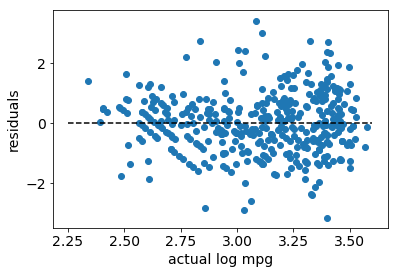

In [51]:
stud_resids3 = results3.outlier_test()['student_resid']

plt.scatter(results3.fittedvalues, stud_resids3)
plt.hlines(0,2.25, 3.6, 'k', linestyle='dashed')
plt.xlabel('actual log mpg')
plt.ylabel('residuals');

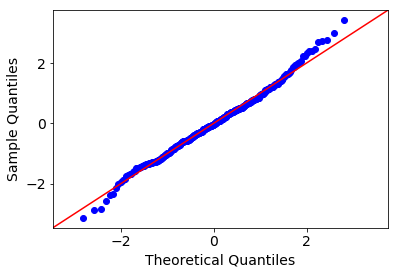

In [52]:
ax = sm.graphics.qqplot(stud_resids3, line='45')

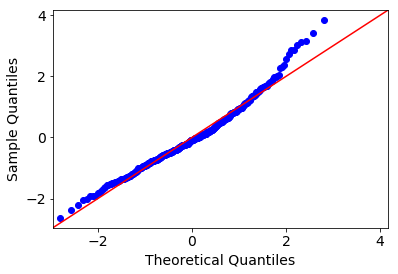

In [53]:
ax = sm.graphics.qqplot(stud_resids, line='45')

## Categorical features: Insects

In [54]:
insects = pd.read_csv('data/insects.csv', sep='\t')
insects.head(10)

,continent,latitude,wingsize,sex
0,1,40.5,941.111111,0
1,1,42.0,924.444444,0
2,1,43.6,924.204444,0
3,1,45.7,915.217778,0
4,1,45.9,905.471111,0
5,1,47.4,896.004444,0
6,1,50.0,913.000000,0
7,1,51.8,916.440000,0
8,1,53.8,933.417778,0
9,1,54.8,934.240000,0


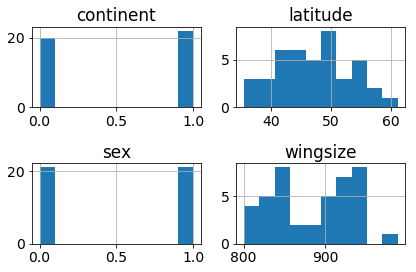

In [55]:
insects.hist()
plt.tight_layout();

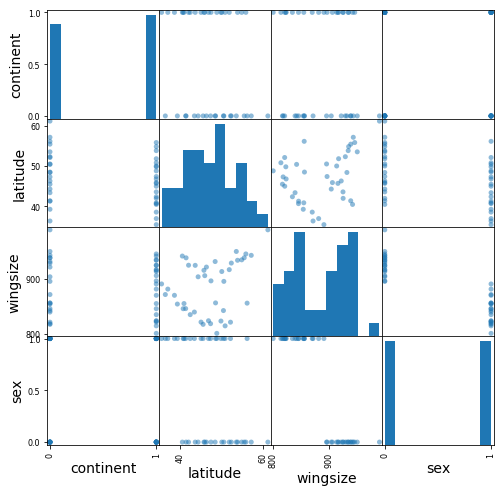

In [56]:
pd.plotting.scatter_matrix(insects, figsize=(8, 8), s=100);

`wing size` vs `latitude` looks interesting. enhance!

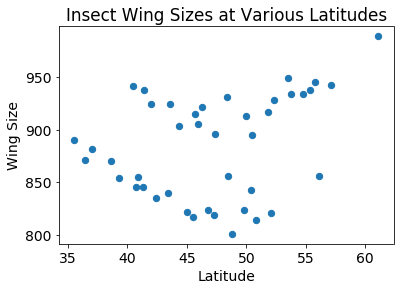

In [57]:
plt.scatter(insects['latitude'], insects['wingsize'], s=40)
plt.xlabel("Latitude")
plt.ylabel("Wing Size")
plt.title("Insect Wing Sizes at Various Latitudes");

### Are The Two Clusters Associated With Either Continent or Sex?

We can discover if the two clusters in the data are associated with either `continent` or `sex` through a well chosen visualization.  Let's make the same scatterplot from before, but color each point either red or blue, according to the value of `continent` or `sex`.

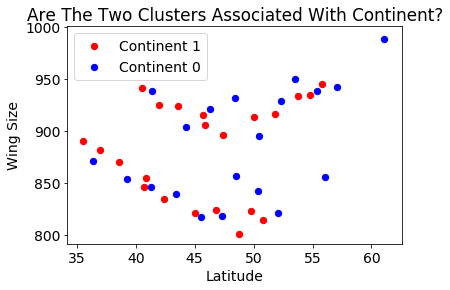

In [58]:
continent_boolean = insects['continent'].astype(bool)
plt.scatter(insects['latitude'][continent_boolean], 
           insects['wingsize'][continent_boolean], 
           s=40, c="red", label="Continent 1")
plt.scatter(insects['latitude'][~continent_boolean], 
           insects['wingsize'][~continent_boolean],
           s=40, c="blue", label="Continent 0")
plt.xlabel("Latitude")
plt.ylabel("Wing Size")
plt.title("Are The Two Clusters Associated With Continent?")
plt.legend();

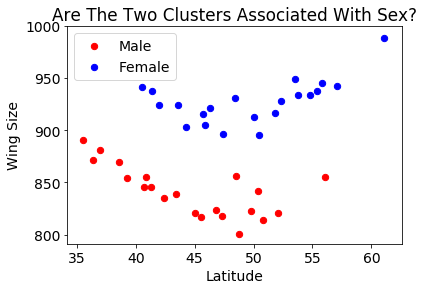

In [59]:
def make_insect_scatter():
    sex_boolean = insects['sex'].astype(bool)
    plt.scatter(insects['latitude'][sex_boolean], 
               insects['wingsize'][sex_boolean], 
               s=40, c="red", label="Male")
    plt.scatter(insects['latitude'][~sex_boolean], 
               insects['wingsize'][~sex_boolean],
               s=40, c="blue", label="Female")
    plt.xlabel("Latitude")
    plt.ylabel("Wing Size")
    plt.title("Are The Two Clusters Associated With Sex?")
    plt.legend()

make_insect_scatter()

In [60]:
linear_model = sm.OLS(insects['wingsize'], sm.add_constant(insects['latitude']))
insects_model = linear_model.fit()
insects_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4.595
Date:                Tue, 25 Sep 2018   Prob (F-statistic):             0.0382
Time:                        16:40:25   Log-Likelihood:                -220.17
No. Observations:                  42   AIC:                             444.3
Df Residuals:                      40   BIC:                             447.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        765.1966     56.276     13.597      0.000     651.458     878.935
latitude       2.5400      1.185      2.144      0.038       0.145       4.935
==============================================================================
Omnibus:                        7.752   Durbin-Watson:                   0.301
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                3.189
Skew:                          -0.380   Prob(JB):                        0.203
Kurtosis:                       1.884   Cond. No.                         370.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

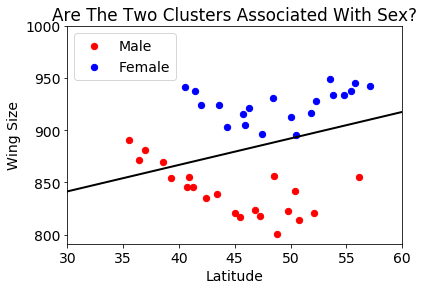

In [61]:
make_insect_scatter()

def plot_predicted_line():
    x = np.linspace(30, 60, num=250)
    plt.plot(x, insects_model.params[0] + insects_model.params[1] * x,
               linewidth=2, c="black")
    plt.xlim(30, 60);
    
plot_predicted_line()

## Accounting for the sex of the insect

It would much better to take account of the sex of the insect and fit two lines, we make one line of prediction of the wing size given the latitude for males, and another for females.

The easiest way to do this is to modify our equation:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Sex} $$

There is now another term: if the insect is male we *add $c$* to the prediction, otherwise we add nothing.

Again, linear regression can find an equation of this shape describing the data:

In [62]:
linear_model = sm.OLS(insects['wingsize'], sm.add_constant(insects[['latitude','sex']]))
insects_model_with_sex = linear_model.fit()
insects_model_with_sex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     75.12
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           4.21e-14
Time:                        16:40:26   Log-Likelihood:                -189.29
No. Observations:                  42   AIC:                             384.6
Df Residuals:                      39   BIC:                             389.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        948.2463     31.665     29.947      0.000     884.199    1012.294
latitude      -0.4120      0.630     -0.653      0.517      -1.687       0.863
sex          -88.0281      7.699    -11.434      0.000    -103.600     -72.456
==============================================================================
Omnibus:                        3.802   Durbin-Watson:                   0.890
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                2.698
Skew:                           0.587   Prob(JB):                        0.259
Kurtosis:                       3.404   Cond. No.                         432.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

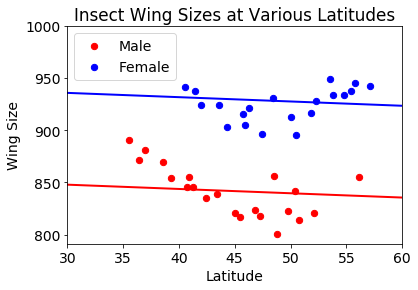

In [63]:
fig, ax = plt.subplots()

make_insect_scatter()

def make_insects_model_lines():
    x = np.linspace(30, 60, num=250)
    plt.plot(x, insects_model_with_sex.params[0] 
                 + insects_model_with_sex.params[1] * x,
           linewidth=2, c="blue")
    plt.plot(x, insects_model_with_sex.params[0] 
                 + insects_model_with_sex.params[1] * x + insects_model_with_sex.params[2],
           linewidth=2, c="red")
    plt.xlim(30, 60)
    plt.xlabel("Latitude")
    plt.ylabel("Wing Size")
    plt.title("Insect Wing Sizes at Various Latitudes")
    plt.legend()
    
make_insects_model_lines()

### Interaction term:
$ y \sim a + b*Latitude + c*Sex*Latitude$

In [64]:
insects['interaction'] = insects['sex']*insects['latitude']

linear_model = sm.OLS(insects['wingsize'], sm.add_constant(insects[['latitude', 'interaction']]))
insects_model_inter = linear_model.fit()
insects_model_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     102.9
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           2.79e-16
Time:                        16:40:26   Log-Likelihood:                -183.89
No. Observations:                  42   AIC:                             373.8
Df Residuals:                      39   BIC:                             379.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         905.2735     26.186     34.570      0.000     852.306     958.241
latitude        0.4727      0.529      0.894      0.377      -0.597       1.542
interaction    -1.9151      0.143    -13.436      0.000      -2.203      -1.627
==============================================================================
Omnibus:                        1.979   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                1.339
Skew:                           0.434   Prob(JB):                        0.512
Kurtosis:                       3.113   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

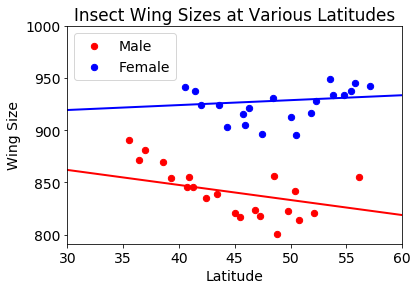

In [65]:
# Make a scatterplot of the data.
make_insect_scatter()

def make_insects_model_interaction():
    x = np.linspace(30, 60, num=250)
    plt.plot(x, insects_model_inter.params[0] 
                 + insects_model_inter.params[1] * x,
           linewidth=2, c="blue")
    plt.plot(x, insects_model_inter.params[0] 
                 + (insects_model_inter.params[1] + 
                    insects_model_inter.params[2])*x,
           linewidth=2, c="red")
    plt.xlim(30, 60)
    plt.xlabel("Latitude")
    plt.ylabel("Wing Size")
    plt.title("Insect Wing Sizes at Various Latitudes")
    plt.legend()
    
make_insects_model_interaction()

### Accounting for the Curvature of the Data Points

We can account for the curvature of the data points by using a *polynomial regression*.  This means that we fit powers of latitude bigger than one:

$$ \text{Wing Span} \approx a + b \times \text{Latitude} + c \times \text{Latitude}^2 +  d \times \text{Sex} $$

In [66]:
insects['lat_sq'] = insects['latitude']**2

In [67]:
linear_model = sm.OLS(insects['wingsize'], sm.add_constant(insects[['latitude','lat_sq','sex']]))
insects_model_quad = linear_model.fit()
insects_model_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     245.6
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           6.48e-25
Time:                        16:40:26   Log-Likelihood:                -159.14
No. Observations:                  42   AIC:                             326.3
Df Residuals:                      38   BIC:                             333.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1946.8863     91.875     21.191      0.000    1760.895    2132.878
latitude     -43.2140      3.893    -11.101      0.000     -51.094     -35.334
lat_sq         0.4513      0.041     11.031      0.000       0.368       0.534
sex          -89.4629      3.807    -23.499      0.000     -97.170     -81.756
==============================================================================
Omnibus:                        5.109   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.052
Skew:                           0.508   Prob(JB):                        0.132
Kurtosis:                       4.133   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

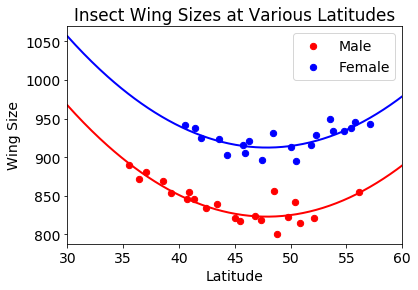

In [68]:
# Make a scatterplot of the data.
make_insect_scatter()

def make_insects_model_quadratic():
    x = np.linspace(30, 60, num=250)
    plt.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad.params[1] * x
                 + insects_model_quad.params[2] * x*x,
           linewidth=2, c="blue")
    plt.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad.params[1] * x
                 + insects_model_quad.params[2] * x*x
                 + insects_model_quad.params[3],
           linewidth=2, c="red")
    plt.xlim(30, 60)
    plt.xlabel("Latitude")
    plt.ylabel("Wing Size")
    plt.title("Insect Wing Sizes at Various Latitudes")
    plt.legend()
    
make_insects_model_quadratic()

In [69]:
linear_model = sm.OLS(insects['wingsize'], sm.add_constant(insects[['latitude','lat_sq','sex', 'continent']]))
insects_model_quad_with_continent = linear_model.fit()
insects_model_quad_with_continent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               wingsize   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     186.1
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           5.83e-24
Time:                        16:40:27   Log-Likelihood:                -158.41
No. Observations:                  42   AIC:                             326.8
Df Residuals:                      37   BIC:                             335.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1945.3896     91.505     21.260      0.000    1759.983    2130.796
latitude     -42.9562      3.883    -11.062      0.000     -50.824     -35.088
lat_sq         0.4477      0.041     10.953      0.000       0.365       0.530
sex          -89.9019      3.811    -23.593      0.000     -97.623     -82.181
continent     -4.1069      3.580     -1.147      0.259     -11.361       3.148
==============================================================================
Omnibus:                        2.477   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.455
Skew:                           0.257   Prob(JB):                        0.483
Kurtosis:                       3.753   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

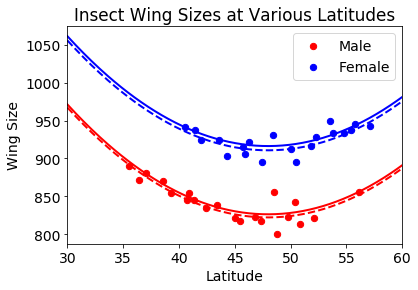

In [70]:
fig, ax = plt.subplots()

# Make a scatterplot of the data.
make_insect_scatter()

def make_insects_model_quadratic_and_continent(ax):
    x = np.linspace(30, 60, num=250)
    ax.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad_with_continent.params[1] * x
                 + insects_model_quad_with_continent.params[2] * x*x,
           linewidth=2, c="blue")
    ax.plot(x, insects_model_quad_with_continent.params[0] 
                 + insects_model_quad_with_continent.params[1] * x
                 + insects_model_quad_with_continent.params[2] * x*x
                 + insects_model_quad_with_continent.params[4],
           linewidth=2, c="blue", linestyle="--")
    ax.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad_with_continent.params[1] * x
                 + insects_model_quad_with_continent.params[2] * x*x
                 + insects_model_quad_with_continent.params[3],
           linewidth=2, c="red")
    ax.plot(x, insects_model_quad.params[0] 
                 + insects_model_quad_with_continent.params[1] * x
                 + insects_model_quad_with_continent.params[2] * x*x
                 + insects_model_quad_with_continent.params[3]
                 + insects_model_quad_with_continent.params[4],
           linewidth=2, c="red", linestyle="--")
    ax.set_xlim(30, 60)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Wing Size")
    ax.set_title("Insect Wing Sizes at Various Latitudes")
    ax.legend()
    
make_insects_model_quadratic_and_continent(plt.gca())